# Data Analysis

Approach:

    Preprocess Images: Convert them to grayscale, normalize, and subtract the baseline from the active image.
    Segment Active Regions: Use OpenCV or a deep learning model to detect the highlighted brain regions.
    Identify the Region: Use a pre-trained model (e.g., a convolutional neural network trained on brain MRI scans) or a simple region-based lookup to determine which part of the brain is active.
    Overlay Annotations: Draw text labels or bounding boxes on the image.

## Imports, Settings, & Function Definitions

In [1]:
from moviepy import VideoFileClip
import librosa
from IPython.display import Audio as IPDAudio
from IPython.display import display, Image, Video
from transformers import pipeline
from datasets import Audio as Datasets_Audio
from datasets import Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
from sklearn.metrics import accuracy_score
import cv2
import time
from glob import glob
import os
import mediapipe as mp
from torch.utils.data import Dataset, DataLoader
import torch

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as tv_datasets
import torchvision.models as models

from PIL import Image as PIL_Image
import shutil
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import random_split


In [2]:
def extract_audio_from_video(video_file_path, audio_output_path):
    """
    This function will accept a video file path and output
    the extracted audio.

    Parameters
    ----------
    video_file_path : string
        This is the path to the mp4 video.
    audio_output_path : string
        This is the path to the output audio wav file.
    """
    video = VideoFileClip(video_file_path)
    audio = video.audio
    audio.write_audiofile(audio_output_path)

In [3]:
# Define the function to extract MFCC features
def extract_mfcc(audio_path, sr=22050, n_mfcc=40, max_len=50):
    y, sr = librosa.load(audio_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Pad or truncate to max_len
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode="constant")
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc

In [4]:
# Save the model state_dict
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [5]:
# Define CNN Model
class NeuralDataExpert(nn.Module):
    def __init__(self):
        super(NeuralDataExpert, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)  # Binary classification (Laughter vs. Non-Laughter)
        self.brain_modality_mean = [17.6743, 17.4406, 17.1653]
        self.brain_modality_std = [7.7531, 8.4884, 9.5815]
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
                transforms.Normalize(mean=self.brain_modality_mean, std=self.brain_modality_std)
        ])
    
    def forward(self, x):
        return self.model(x)

In [6]:
class AudioClassifier(nn.Module):
    def __init__(self, n_mfcc=40, max_len=96):
        super(AudioClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # Compute the output size after pooling
        fc_input_size = 32 * (n_mfcc // 4) * (max_len // 4)  # 2 pooling layers divide by 4
        
        self.fc1 = nn.Linear(fc_input_size, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [7]:
def load_torch_model(model_file_path, modelClass):
    """
    This will return the loaded model using the 
    file path. It will use cuda if available.

    Parameters
    ----------
    model_file_path : str
        This is the path of the stored pytorch model.
    model : nn.Module class
        This is the model definition used to define
        the model that is loaded.
    """
    model = modelClass()
    model.load_state_dict(torch.load(model_file_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
    
    return model

## Data Collection

In [8]:
# Total Video
video_file_path = '../data/kernel-brain-data-jokes-lex-only-training-set.mp4'
audio_file_path = '../data/kernel-brain-data-jokes-lex-only-training-set.wav'

# Laughter Training Samples
video_file_path_laughter_train = '../data/laughter-only/kernel-brain-data-jokes-lex-only-train-laughter-only.mp4'
audio_file_path_laughter_train = '../data/laughter-only/kernel-brain-data-jokes-lex-only-train-laughter-only.wav'

# Non-Laughter Training Samples
video_file_path_non_laughter_train = '../data/non-laughter/kernel-brain-data-jokes-lex-only-training-set-non-laughter.mp4'
audio_file_path_non_laughter_train = '../data/non-laughter/kernel-brain-data-jokes-lex-only-training-set-non-laughter.wav'

# All Frames
# laughter_all_frames = np.load('../data/laughter-only/laughter_all_frames.npy')
# non_laughter_all_frames = np.load('../data/non-laughter/non_laughter_all_frames.npy')

# Separated aughter Only
# lex_human_laughter_only_np = np.load('../data/laughter-only/lex_human_laughter_only.npy')
lex_brain_laughter_only_np = np.load("../data/laughter-only/lex_brain_laughter_only.npy")

# Separated Non-Laughter
# lex_human_non_laughter_np = np.load('../data/non-laughter/lex_human_non_laughter.npy')
lex_brain_non_laughter_np = np.load('../data/non-laughter/lex_brain_non_laughter.npy')

# Data by modality
brain_data_path = '../data/modalities/brain/'
audio_data_path = '../data/modalities/audio/'
human_data_path = '../data/modalities/human/'

# Trained & Tested Models
neural_data_model_f_path = '../models/neural_image_classifier_model.pth'
audio_laughter_classifier_model_path = '../models/audio_classifier_model.pth'
neural_data_model = load_torch_model(neural_data_model_f_path, NeuralDataExpert)
audio_laughter_classifier_model = load_torch_model(audio_laughter_classifier_model_path, AudioClassifier)


/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Total Video Preprocessing

In [ ]:
audio_data, sample_rate = librosa.load(audio_file_path)
IPDAudio(data=audio_data, rate=sample_rate)

In [ ]:
Video(video_file_path)

In [ ]:
cap = cv2.VideoCapture(video_file_path)

In [ ]:
# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = int(total_frames / fps)  # Duration in seconds

In [ ]:
# Extract one frame per second
frames = []
for sec in tqdm(range(duration), desc="Extracting one frame per second...", ascii="░▒▓█"):
    cap.set(cv2.CAP_PROP_POS_MSEC, sec * 1000)  # Move to the timestamp (sec * 1000ms)
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
    frames.append(frame)

cap.release()  # Release the video file


In [ ]:
index = 0

In [ ]:
# View all frames
index += 1 
index = index % len(frames)

plt.figure(figsize=(12, 8))
plt.imshow(frames[index])
plt.axis('off')
plt.tight_layout()
plt.show()
index

## Laughter Samples

### Sample Extraction

In [ ]:
cap = cv2.VideoCapture(video_file_path_laughter_train)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = int(total_frames / fps)  # Duration in seconds

In [ ]:
total_frames

In [ ]:
laughter_all_frames = []
progress_bar = tqdm(total=cap.get(cv2.CAP_PROP_FRAME_COUNT), desc="Processing Frames", unit="frame")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    laughter_all_frames.append(frame)
    progress_bar.update(1)
cap.release()
cv2.destroyAllWindows()
progress_bar.close()

In [ ]:
audio_data, sample_rate = librosa.load(audio_file_path_laughter_train)
IPDAudio(data=audio_data, rate=sample_rate)

### Extracting the Neural Data Frame

In [ ]:
index = 0

In [ ]:
index += 1
index %= len(laughter_all_frames)
plt.imshow(cv2.cvtColor(laughter_all_frames[index], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
index 

In [ ]:
laughter_all_frames[index].shape

In [12]:
lex_brain_regions = {"lex_brain_y_t":600}
lex_brain_regions["lex_brain_y_b"] = 1400
lex_brain_regions["lex_brain_x_l"] = 1900
lex_brain_regions["lex_brain_x_r"] = 2950

In [13]:
lex_human_regions = {}
lex_human_regions["lex_human_y_t"] = 0
lex_human_regions["lex_human_y_b"] = 1440
lex_human_regions["lex_human_x_l"] = 500
lex_human_regions["lex_human_x_r"] = 1800


In [ ]:
plt.imshow(laughter_all_frames[0][:, lex_human_regions["lex_human_x_l"]:lex_human_regions["lex_human_x_r"], :])

In [ ]:
# Collect Lex Human Laughter Only
lex_human_laughter_only = []
for frame in tqdm(range(len(laughter_all_frames)), desc="Extracting Lex Only Laughter Frames...", ascii="░▒▓█"):
    lex_human_laughter_only.append(laughter_all_frames[frame][:, lex_human_regions["lex_human_x_l"]:lex_human_regions["lex_human_x_r"], :])
lex_human_laughter_only_np = np.array(lex_human_laughter_only)

In [ ]:
np.save('../data/laughter-only/lex_human_laughter_only.npy', lex_human_laughter_only_np)

In [ ]:
plt.imshow(laughter_all_frames[0][600:1400, 1900:2950, :])

In [ ]:
# Collect Lex Brain Laughter Only
lex_brain_laughter_only = []
for frame in tqdm(range(len(laughter_all_frames)), desc="Extracting Brain Only Laughter Frames...", ascii="░▒▓█"):
    lex_brain_laughter_only.append(laughter_all_frames[frame][lex_brain_regions["lex_brain_y_t"]:lex_brain_regions["lex_brain_y_b"], lex_brain_regions["lex_brain_x_l"]:lex_brain_regions["lex_brain_x_r"], :])
lex_brain_laughter_only_np = np.array(lex_brain_laughter_only)
np.save("../data/laughter-only/lex_brain_laughter_only.npy", lex_brain_laughter_only_np)

## Non-Laughter Samples

### Sample Extraction

In [571]:
video_file_path_non_laughter_train

'../data/non-laughter/kernel-brain-data-jokes-lex-only-training-set-non-laughter.mp4'

In [572]:
audio_data, sample_rate = librosa.load(audio_file_path_non_laughter_train)
IPDAudio(data=audio_data, rate=sample_rate)

In [573]:
cap = cv2.VideoCapture(video_file_path_non_laughter_train)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = int(total_frames / fps)  # Duration in seconds
total_frames

339

In [574]:
non_laughter_all_frames = []
progress_bar = tqdm(total=cap.get(cv2.CAP_PROP_FRAME_COUNT), desc="Processing Frames", unit="frame")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    non_laughter_all_frames.append(frame)
    progress_bar.update(1)
cap.release()
cv2.destroyAllWindows()
progress_bar.close()

Processing Frames: 100%|██████████| 339/339.0 [00:02<00:00, 160.78frame/s]


In [ ]:
# np.save('../data/non-laughter/non_laughter_all_frames.npy', np.array(non_laughter_all_frames))

In [ ]:
len(laughter_all_frames)

In [ ]:
len(non_laughter_all_frames)

In [580]:
# Collect Lex Human Non Laughter
lex_human_non_laughter = []
for frame in tqdm(range(len(non_laughter_all_frames)), desc="Extracting Lex Only Non Laughter Frames...", ascii="░▒▓█"):
    lex_human_non_laughter.append(non_laughter_all_frames[frame][:, lex_human_regions["lex_human_x_l"]:lex_human_regions["lex_human_x_r"], :])
lex_human_non_laughter_np = np.array(lex_human_non_laughter)
np.save('../data/non-laughter/lex_human_non_laughter.npy', lex_human_non_laughter_np)

Extracting Lex Only Non Laughter Frames...: 100%|██████████| 339/339 [00:00<00:00, 316674.62it/s]


In [ ]:
lex_brain_non_laughter = []
for frame in tqdm(range(len(non_laughter_all_frames)), desc="Extracting Lex Only Non Laughter Brain Frames...", ascii="░▒▓█"):
    lex_brain_non_laughter.append(non_laughter_all_frames[frame][lex_brain_regions["lex_brain_y_t"]:lex_brain_regions["lex_brain_y_b"], lex_brain_regions["lex_brain_x_l"]:lex_brain_regions["lex_brain_x_r"], :])
lex_brain_non_laughter_np = np.array(lex_brain_non_laughter)
# np.save('../data/non-laughter/lex_brain_non_laughter.npy', lex_brain_non_laughter_np)


Extracting Lex Only Non Laughter Brain Frames...: 100%|██████████| 339/339 [00:00<00:00, 705992.58it/s]


### Extracting the Neural Data Frame (Non-Laughter)

In [ ]:
# Collect Lex Human Non Laughter
lex_human_non_laughter = []
for frame in tqdm(range(len(non_laughter_all_frames)), desc="Extracting Lex Only Non Laughter Frames...", ascii="░▒▓█"):
    lex_human_non_laughter.append(non_laughter_all_frames[frame][:, lex_human_regions["lex_human_x_l"]:lex_human_regions["lex_human_x_r"], :])
lex_human_non_laughter_np = np.array(lex_human_non_laughter)
# np.save('../data/non-laughter/lex_human_non_laughter.npy', lex_human_non_laughter_np)

Extracting Lex Only Non Laughter Frames...:   0%|░░░░░░░░░░| 0/339 [00:00<?, ?it/s]


NameError: name 'lex_human_regions' is not defined

In [ ]:
lex_brain_non_laughter = []
for frame in tqdm(range(len(non_laughter_all_frames)), desc="Extracting Lex Only Non Laughter Brain Frames...", ascii="░▒▓█"):
    lex_brain_non_laughter.append(non_laughter_all_frames[frame][lex_brain_regions["lex_brain_y_t"]:lex_brain_regions["lex_brain_y_b"], lex_brain_regions["lex_brain_x_l"]:lex_brain_regions["lex_brain_x_r"], :])
lex_brain_non_laughter_np = np.array(lex_brain_non_laughter)
np.save('../data/non-laughter/lex_brain_non_laughter.npy', lex_brain_non_laughter_np)


## Test Non-Laughter

In [9]:
video_file_path = "../data/lex-attempting-not-to-laugh-no-audible-laughter.mp4"

In [10]:
cap = cv2.VideoCapture(video_file_path)

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = int(total_frames / fps)  # Duration in seconds

In [11]:
non_laughter_all_frames = []
progress_bar = tqdm(total=cap.get(cv2.CAP_PROP_FRAME_COUNT), desc="Processing Frames", unit="frame")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    non_laughter_all_frames.append(frame)
    progress_bar.update(1)
cap.release()
cv2.destroyAllWindows()
progress_bar.close()

Processing Frames: 100%|██████████| 267/267.0 [00:01<00:00, 151.13frame/s]


In [14]:
# Collect Lex Human Non Laughter
lex_human_non_laughter = []
for frame in tqdm(range(len(non_laughter_all_frames)), desc="Extracting Lex Only Non Laughter Frames...", ascii="░▒▓█"):
    lex_human_non_laughter.append(non_laughter_all_frames[frame][:, lex_human_regions["lex_human_x_l"]:lex_human_regions["lex_human_x_r"], :])
lex_human_non_laughter_np = np.array(lex_human_non_laughter)
# np.save('../data/non-laughter/lex_human_non_laughter.npy', lex_human_non_laughter_np)

Extracting Lex Only Non Laughter Frames...: 100%|██████████| 267/267 [00:00<00:00, 970432.55it/s]


In [15]:
lex_brain_non_laughter = []
for frame in tqdm(range(len(non_laughter_all_frames)), desc="Extracting Lex Only Non Laughter Brain Frames...", ascii="░▒▓█"):
    lex_brain_non_laughter.append(non_laughter_all_frames[frame][lex_brain_regions["lex_brain_y_t"]:lex_brain_regions["lex_brain_y_b"], lex_brain_regions["lex_brain_x_l"]:lex_brain_regions["lex_brain_x_r"], :])
lex_brain_non_laughter_np = np.array(lex_brain_non_laughter)
# np.save('../data/non-laughter/lex_brain_non_laughter.npy', lex_brain_non_laughter_np)


Extracting Lex Only Non Laughter Brain Frames...: 100%|██████████| 267/267 [00:00<00:00, 846469.51it/s]


In [16]:
# Creating Brain Dataset Non-Laughter
f_dir = '../data/non-laughter/test/brain/'
for index in tqdm(range(len(lex_brain_non_laughter_np)), desc="Saving Frames as Images...", ascii="░▒▓█"):
    f_name = f"lex_brain_non_laughter_test_{index}.png"
    PIL_Image.fromarray(lex_brain_non_laughter_np[index].astype(np.uint8)).save(f_dir + f_name)

Saving Frames as Images...: 100%|██████████| 267/267 [00:23<00:00, 11.42it/s]


In [17]:
# Creating Human Dataset Non-Laughter
f_dir = '../data/non-laughter/test/human/'
for index in tqdm(range(len(lex_human_non_laughter_np)), desc="Saving Frames as Images...", ascii="░▒▓█"):
    f_name = f"lex_human_non_laughter_test_{index}.png"
    PIL_Image.fromarray(lex_human_non_laughter_np[index].astype(np.uint8)).save(f_dir + f_name)

Saving Frames as Images...: 100%|██████████| 267/267 [00:40<00:00,  6.59it/s]


## Creating Datasets

In [ ]:
# # Creating Brain Dataset Laughter
# f_dir = '../data/laughter-only/brain/'
# for index in tqdm(range(len(lex_brain_laughter_only_np)), desc="Saving Frames as Images...", ascii="░▒▓█"):
#     f_name = f"lex_brain_laughter_only_{index}.png"
#     PIL_Image.fromarray(lex_brain_laughter_only_np[index].astype(np.uint8)).save(f_dir + f_name)

Saving Frames as Images...: 100%|██████████| 279/279 [00:24<00:00, 11.43it/s]


In [ ]:
# # Creating Brain Dataset Non-Laughter
# f_dir = '../data/non-laughter/brain/'
# for index in tqdm(range(len(lex_brain_non_laughter_np)), desc="Saving Frames as Images...", ascii="░▒▓█"):
#     f_name = f"lex_brain_non_laughter_{index}.png"
#     PIL_Image.fromarray(lex_brain_non_laughter_np[index].astype(np.uint8)).save(f_dir + f_name)

Saving Frames as Images...: 100%|██████████| 339/339 [00:27<00:00, 12.43it/s]


In [ ]:
# # Creating Human Dataset Laughter
# f_dir = '../data/laughter-only/human/'
# for index in tqdm(range(len(lex_human_laughter_only_np)), desc="Saving Frames as Images...", ascii="░▒▓█"):
#     f_name = f"lex_human_laughter_only_{index}.png"
#     PIL_Image.fromarray(lex_human_laughter_only_np[index].astype(np.uint8)).save(f_dir + f_name)

Saving Frames as Images...: 100%|██████████| 279/279 [00:42<00:00,  6.57it/s]


In [ ]:
# # Creating Human Dataset Non-Laughter
# f_dir = '../data/non-laughter/human/'
# for index in tqdm(range(len(lex_human_non_laughter_np)), desc="Saving Frames as Images...", ascii="░▒▓█"):
#     f_name = f"lex_human_non_laughter_{index}.png"
#     PIL_Image.fromarray(lex_human_non_laughter_np[index].astype(np.uint8)).save(f_dir + f_name)

Saving Frames as Images...: 100%|██████████| 339/339 [00:46<00:00,  7.27it/s]


In [ ]:
# Collecting audio lecture segments
smile_data_dir = '../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/'
non_laughter_audio_segment_file_paths = glob(smile_data_dir + "*_*_*")
single_underscore_file_candidates = glob(smile_data_dir + '*_*')
laughter_only_audio_segment_file_paths = [file for file in single_underscore_file_candidates if os.path.basename(file).count('_') == 1]

In [ ]:
# len(laughter_only_audio_segment_file_paths)

2546

In [ ]:
# len(non_laughter_audio_segment_file_paths)

1936

In [109]:
destination_folder_laughter = '../data/modalities/audio/laughter-only-mp4'
destination_folder_non_laughter = '../data/modalities/audio/non-laughter-mp4'

In [ ]:
# for file_path in tqdm(non_laughter_audio_segment_file_paths, desc="Copying non-laughter audio segments...", ascii="░▒▓█"):
#     # Get the filename from the file path
#     filename = os.path.basename(file_path)
    
#     # Construct the destination file path
#     destination_path = os.path.join(destination_folder_non_laughter, filename)
    
#     # Copy the file to the destination folder
#     shutil.copy(file_path, destination_path)
    
#     print(f"Copied {file_path} to {destination_path}")

Copying non-laughter audio segments...:  22%|██░░░░░░░░| 429/1936 [00:00<00:00, 2231.81it/s]

Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_5134_00.mp4 to ../data/modalities/audio/non-laughter-mp4/1_5134_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_158_01.mp4 to ../data/modalities/audio/non-laughter-mp4/2_158_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_9971_02.mp4 to ../data/modalities/audio/non-laughter-mp4/1_9971_02.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_9963_06.mp4 to ../data/modalities/audio/non-laughter-mp4/1_9963_06.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_4352_05.mp4 to ../data/modalities/audio/non-laughter-mp4/1_4352_05.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_449_03.mp4 to ../data/modalities/audio/non-laughter-mp4/2_449_03.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASE

Copying non-laughter audio segments...:  34%|███▒░░░░░░| 651/1936 [00:00<00:00, 1650.48it/s]

Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_494_01.mp4 to ../data/modalities/audio/non-laughter-mp4/2_494_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_280_01.mp4 to ../data/modalities/audio/non-laughter-mp4/2_280_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_3766_03.mp4 to ../data/modalities/audio/non-laughter-mp4/1_3766_03.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_508_02.mp4 to ../data/modalities/audio/non-laughter-mp4/2_508_02.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_10849_05.mp4 to ../data/modalities/audio/non-laughter-mp4/1_10849_05.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_6427_03.mp4 to ../data/modalities/audio/non-laughter-mp4/1_6427_03.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASE

Copying non-laughter audio segments...:  51%|█████░░░░░| 996/1936 [00:00<00:00, 1586.19it/s]

Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_11006_04.mp4 to ../data/modalities/audio/non-laughter-mp4/1_11006_04.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_380_01.mp4 to ../data/modalities/audio/non-laughter-mp4/2_380_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_11051_00.mp4 to ../data/modalities/audio/non-laughter-mp4/1_11051_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_502_00.mp4 to ../data/modalities/audio/non-laughter-mp4/2_502_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_1722_00.mp4 to ../data/modalities/audio/non-laughter-mp4/1_1722_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_7445_05.mp4 to ../data/modalities/audio/non-laughter-mp4/1_7445_05.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DA

Copying non-laughter audio segments...:  60%|█████▓░░░░| 1160/1936 [00:00<00:00, 1386.98it/s]

Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_258_05.mp4 to ../data/modalities/audio/non-laughter-mp4/2_258_05.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_604_01.mp4 to ../data/modalities/audio/non-laughter-mp4/2_604_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_508_01.mp4 to ../data/modalities/audio/non-laughter-mp4/2_508_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_213_00.mp4 to ../data/modalities/audio/non-laughter-mp4/1_213_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_11699_01.mp4 to ../data/modalities/audio/non-laughter-mp4/1_11699_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_518_02.mp4 to ../data/modalities/audio/non-laughter-mp4/2_518_02.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/vi

Copying non-laughter audio segments...:  76%|███████▒░░| 1478/1936 [00:00<00:00, 1400.90it/s]

Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_10829_05.mp4 to ../data/modalities/audio/non-laughter-mp4/1_10829_05.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_2575_04.mp4 to ../data/modalities/audio/non-laughter-mp4/1_2575_04.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_2075_04.mp4 to ../data/modalities/audio/non-laughter-mp4/1_2075_04.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_223_03.mp4 to ../data/modalities/audio/non-laughter-mp4/2_223_03.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_5109_04.mp4 to ../data/modalities/audio/non-laughter-mp4/1_5109_04.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_7487_00.mp4 to ../data/modalities/audio/non-laughter-mp4/1_7487_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DA

Copying non-laughter audio segments...:  93%|█████████░| 1800/1936 [00:01<00:00, 1495.01it/s]

Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_73_01.mp4 to ../data/modalities/audio/non-laughter-mp4/2_73_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_4789_07.mp4 to ../data/modalities/audio/non-laughter-mp4/1_4789_07.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_11928_04.mp4 to ../data/modalities/audio/non-laughter-mp4/1_11928_04.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_169_01.mp4 to ../data/modalities/audio/non-laughter-mp4/2_169_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_526_00.mp4 to ../data/modalities/audio/non-laughter-mp4/2_526_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_6683_01.mp4 to ../data/modalities/audio/non-laughter-mp4/1_6683_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/

Copying non-laughter audio segments...: 100%|██████████| 1936/1936 [00:01<00:00, 1437.95it/s]

Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_3293_02.mp4 to ../data/modalities/audio/non-laughter-mp4/1_3293_02.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_429_02.mp4 to ../data/modalities/audio/non-laughter-mp4/2_429_02.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_124_04.mp4 to ../data/modalities/audio/non-laughter-mp4/2_124_04.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_12002_01.mp4 to ../data/modalities/audio/non-laughter-mp4/1_12002_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/1_8078_00.mp4 to ../data/modalities/audio/non-laughter-mp4/1_8078_00.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASET/videos/SMILE_video/video_segments/2_527_01.mp4 to ../data/modalities/audio/non-laughter-mp4/2_527_01.mp4
Copied ../data/smile/SMILE_DATASET_v2/SMILE_DATASE

In [ ]:
# for file_path in tqdm(laughter_only_audio_segment_file_paths, desc="Copying laughter only audio segments...", ascii="░▒▓█"):
#     # Get the filename from the file path
#     filename = os.path.basename(file_path)
    
#     # Construct the destination file path
#     destination_path = os.path.join(destination_folder_laughter, filename)
    
#     # Copy the file to the destination folder
#     shutil.copy(file_path, destination_path)
    
#     # print(f"Copied {file_path} to {destination_path}")

Copying laughter only audio segments...: 100%|██████████| 2546/2546 [00:01<00:00, 2208.17it/s]


## Facial Emotion Expert

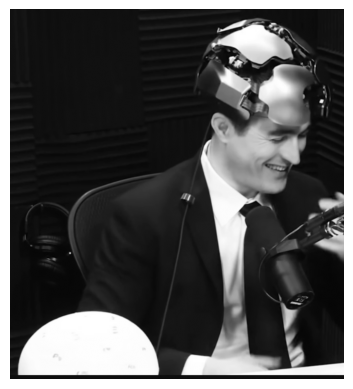

In [4]:
lex_human_laughter_only_gray_np_img = cv2.cvtColor(lex_human_laughter_only_np[0], cv2.COLOR_BGR2GRAY)
plt.imshow(lex_human_laughter_only_gray_np_img, cmap="gray")
lex_human_laughter_only_gray_np_img.shape
plt.axis('off')
plt.show()
# plt.imshow(lex_human_laughter_only_gray_np[0])

### Extract Face Mesh

In [ ]:
# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

def extract_landmarks(image_path):
    # Read and process image
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_image)

    # Extract landmarks
    landmarks = []
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for landmark in face_landmarks.landmark:
                x, y = landmark.x, landmark.y  # Normalized (0 to 1)
                landmarks.append([x, y])

    if len(landmarks) == 468:  # Ensure full face mesh is detected
        return np.array(landmarks).flatten()  # Convert to 1D array
    else:
        return None  # Skip if face not detected

# Example usage
landmark_vector = extract_landmarks("laughter.jpg")
print(landmark_vector.shape)  # Should be (936,) if all landmarks are found


### Facial Emotion Dataset

In [ ]:
# Custom dataset class
class LaughterDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        landmarks = extract_landmarks(self.image_paths[idx])
        if landmarks is None:
            return None  # Skip if no face detected

        landmarks = torch.tensor(landmarks, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return landmarks, label

# Load dataset
image_paths = ["laugh1.jpg", "serious1.jpg", "laugh2.jpg"]
labels = [1, 0, 1]  # 1 = laughter, 0 = no laughter

dataset = LaughterDataset(image_paths, labels)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


### Facial Emotion Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class LaughterCNN(nn.Module):
    def __init__(self):
        super(LaughterCNN, self).__init__()
        self.fc1 = nn.Linear(936, 256)  # 468 x 2 = 936 input features
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Binary classification (0 = no laughter, 1 = laughter)
        return x

# Initialize model
model = LaughterCNN()


### Facial Emotion Predictions

In [ ]:
def predict_laughter(image_path, model):
    landmarks = extract_landmarks(image_path)
    if landmarks is None:
        return "No Face Detected"
    
    landmarks = torch.tensor(landmarks, dtype=torch.float32).unsqueeze(0)
    model.eval()
    
    with torch.no_grad():
        output = model(landmarks)
        prob = output.item()

    return "Laughter" if prob > 0.5 else "No Laughter"

print(predict_laughter("test_laugh.jpg", model))


## Kernel Neural Image Expert

#### Data Examples

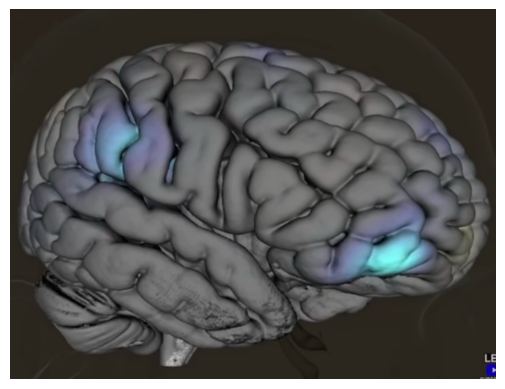

Number of Examples of Laughter: 279


In [8]:
plt.imshow(lex_brain_laughter_only_np[0])
plt.axis('off')
plt.show()
print(f"Number of Examples of Laughter: {len(lex_brain_laughter_only_np)}")

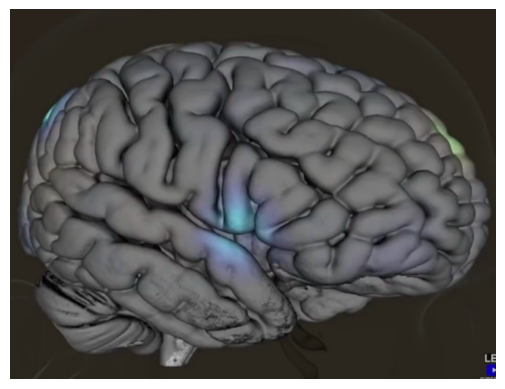

Number of Examples of Non-Laughter: 339


(800, 1050, 3)

In [9]:
plt.imshow(lex_brain_non_laughter_np[0])
plt.axis('off')
plt.show()
print(f"Number of Examples of Non-Laughter: {len(lex_brain_non_laughter_np)}")
lex_brain_non_laughter_np[0].shape

In [100]:
index = 0

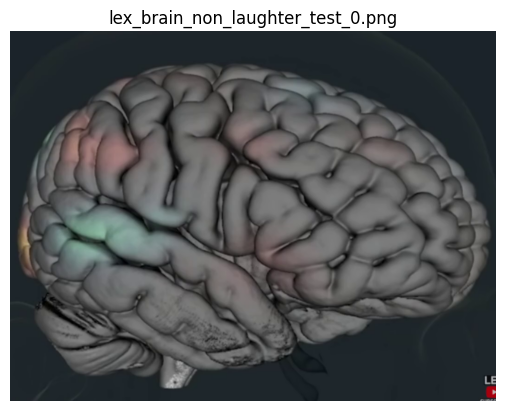

In [195]:
# Testing the trained model

# Load and preprocess the image
# image_path = "../data/lex-brain-laughter-01-27.png"  # Path to your uploaded image
# image_path = "../data/lex-brain-baseline-00-37.png"  # Path to your uploaded image

test_image_path = glob('../data/non-laughter/test/brain/' + "*.png")

# image_path = "../data/lex-non-laughter.png"  # Path to your uploaded image
image_path  = test_image_path[index]

image = PIL_Image.open(image_path).convert("RGB")  # Ensure it's in RGB mode
plt.imshow(cv2.imread(image_path))
plt.title(f"{os.path.basename(image_path)}")
plt.axis('off')
plt.show()
index+=1 
index%=len(test_image_path)

In [196]:

# index += 1
# index %= len(lex_brain_non_laughter_np)
# image = lex_brain_non_laughter_np[index]
# image = PIL_Image.fromarray(image.astype(np.uint8)).convert("RGB")
image = neural_data_model.transform(image).unsqueeze(0)  # Add batch dimension

# plt.imshow(lex_brain_non_laughter_np[index])
# plt.axis('off')
# plt.show()
# print(f"Number of Examples of Non-Laughter: {len(lex_brain_non_laughter_np)}")

neural_data_model.eval()
# Perform inference
with torch.no_grad():
    output = neural_data_model(image)
    _, predicted = torch.max(output, 1)
    prediction = torch.argmax(output, dim=1).item()

# Interpret result
classes = ["Non-Laughter", "Laughter"]
print(f"Predicted class: {classes[prediction]}")
index

Predicted class: Non-Laughter


48

In [197]:
# Calculating Real-World Test Accuracy

image_path  = test_image_path[index]
neural_data_model.eval()
test_truth = np.zeros(len(test_image_path))
predictions = []
for image_path in tqdm(test_image_path, desc="Calculating Test Accuracy...", ascii="░▒▓█"):
    image = PIL_Image.open(image_path).convert("RGB")  # Ensure it's in RGB mode
    image = neural_data_model.transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = neural_data_model(image)
        _, predicted = torch.max(output, 1)
        prediction = torch.argmax(output, dim=1).item()
        predictions.append(prediction)
from sklearn.metrics import accuracy_score
accuracy_score(test_truth, np.array(predictions))

Calculating Test Accuracy...: 100%|██████████| 267/267 [00:09<00:00, 28.58it/s]


0.6554307116104869

In [291]:
index = 0

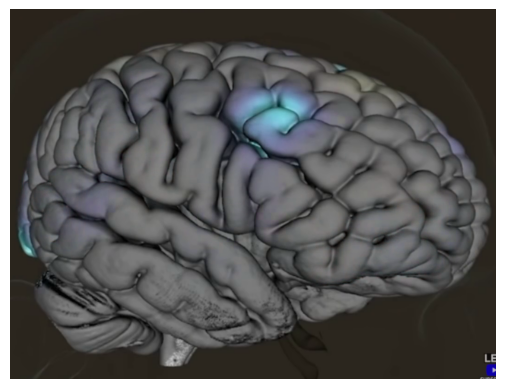

Number of Examples of Non-Laughter: 279
Predicted class: Laughter


249

In [540]:

index += 1
index %= len(lex_brain_laughter_only_np)
image = lex_brain_laughter_only_np[index]
image = PIL_Image.fromarray(image.astype(np.uint8)).convert("RGB")
image = neural_data_model.transform(image).unsqueeze(0)  # Add batch dimension

plt.imshow(lex_brain_laughter_only_np[index])
plt.axis('off')
plt.show()
print(f"Number of Examples of Non-Laughter: {len(lex_brain_laughter_only_np)}")

neural_data_model.eval()
# Perform inference
with torch.no_grad():
    output = neural_data_model(image)
    _, predicted = torch.max(output, 1)
    prediction = torch.argmax(output, dim=1).item()

# Interpret result
classes = ["Non-Laughter", "Laughter"]
print(f"Predicted class: {classes[prediction]}")
index

In [28]:
# Computing the Mean and Variance to Normalize the data:

# Load your dataset
dataset = tv_datasets.ImageFolder(root=brain_data_path, transform=transforms.ToTensor())

# Create a DataLoader to iterate over the dataset
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Initialize variables to compute the mean and std
brain_modality_mean = 0.0
brain_modality_std = 0.0
num_batches = 0

# Iterate over the dataset to compute mean and std
for images, _ in dataloader:
    batch_samples = images.size(0)  # Get the number of images in the batch
    images = images.view(batch_samples, images.size(1), -1)  # Flatten the images
    brain_modality_mean += images.mean(2).sum(0)  # Sum the mean of each image channel
    brain_modality_std += images.std(2).sum(0)    # Sum the std of each image channel
    num_batches += 1

brain_modality_mean /= num_batches  # Average mean over all batches
brain_modality_std /= num_batches    # Average std over all batches

print("Mean:", brain_modality_mean)
print("Std:", brain_modality_std)


Mean: tensor([17.6743, 17.4406, 17.1653])
Std: tensor([7.7531, 8.4884, 9.5815])


In [202]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model input size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=brain_modality_mean, std=brain_modality_std)  # Normalize pixel values
])

In [203]:
# Load dataset (Assuming laughter and non-laughter images are in separate folders)
dataset = tv_datasets.ImageFolder(root=brain_data_path, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [204]:
# Initialize model
neuralModel = NeuralDataExpert().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(neuralModel.parameters(), lr=0.001)

/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [205]:

# Training loop
epochs = 10
for epoch in tqdm(range(epochs), desc="Training...", ascii="░▒▓█"):
    neuralModel.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = neuralModel(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Training...:  10%|█░░░░░░░░░| 1/10 [00:09<01:21,  9.01s/it]

Epoch [1/10], Loss: 0.0315


Training...:  20%|██░░░░░░░░| 2/10 [00:17<01:11,  8.94s/it]

Epoch [2/10], Loss: 0.0146


Training...:  30%|███░░░░░░░| 3/10 [00:26<01:02,  8.93s/it]

Epoch [3/10], Loss: 0.0575


Training...:  40%|████░░░░░░| 4/10 [00:35<00:53,  8.99s/it]

Epoch [4/10], Loss: 0.0003


Training...:  50%|█████░░░░░| 5/10 [00:44<00:44,  8.99s/it]

Epoch [5/10], Loss: 0.0055


Training...:  60%|██████░░░░| 6/10 [00:53<00:35,  8.96s/it]

Epoch [6/10], Loss: 0.0178


Training...:  70%|███████░░░| 7/10 [01:02<00:26,  8.92s/it]

Epoch [7/10], Loss: 0.0008


Training...:  80%|████████░░| 8/10 [01:11<00:17,  8.95s/it]

Epoch [8/10], Loss: 0.0001


Training...:  90%|█████████░| 9/10 [01:20<00:08,  8.92s/it]

Epoch [9/10], Loss: 0.0000


Training...: 100%|██████████| 10/10 [01:29<00:00,  8.93s/it]

Epoch [10/10], Loss: 0.0002


In [206]:
# Evaluation
neuralModel.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = neuralModel(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 100.00%


In [207]:
save_model(neuralModel, "../models/neural_image_classifier_model.pth")

## Audio Laughter Expert

### Define Audio Dataloader

In [ ]:
# class AudioDataset(Dataset):
#     def __init__(self, root_dir, transform=None, sr=22050, n_mfcc=40, max_len=50):
#         self.root_dir = root_dir
#         self.transform = transform
#         self.sr = sr
#         self.n_mfcc = n_mfcc
#         self.max_len = max_len
        
#         # Initialize lists to store file paths and labels
#         self.audio_paths = []
#         self.labels = []
#         self.label_map = {}  # To map folder names to numeric labels

#         # Walk through root directory and get file paths
#         for label_idx, label_name in enumerate(os.listdir(root_dir)):
#             label_path = os.path.join(root_dir, label_name)
#             if os.path.isdir(label_path):  # Check if it's a folder (class)
#                 for file_name in os.listdir(label_path):
#                     if file_name.endswith(".wav"):  # Only .wav files
#                         file_path = os.path.join(label_path, file_name)
#                         self.audio_paths.append(file_path)
#                         self.labels.append(label_idx)  # Assign label based on folder index
                
#                 # Store label name for reference (optional)
#                 self.label_map[label_idx] = label_name

#     def __len__(self):
#         return len(self.audio_paths)

#     def __getitem__(self, idx):
#         audio_path = self.audio_paths[idx]
#         label = torch.tensor(float(self.labels[idx]), dtype=torch.float32)  # BCELoss needs float labels

#         # Extract MFCC features from audio
#         mfcc = extract_mfcc(audio_path, sr=self.sr, n_mfcc=self.n_mfcc, max_len=self.max_len)

#         # Convert to tensor
#         mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32)

#         # Apply transformations (if any)
#         if self.transform:
#             mfcc_tensor = self.transform(mfcc_tensor)
#         mfcc_tensor = mfcc_tensor.unsqueeze(1)
#         return mfcc_tensor, label
    
    
    

In [17]:
class AudioDataset(Dataset):
    def __init__(self, root_dir, sr=22050, n_mfcc=40, max_len=50):
        self.root_dir = root_dir
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.max_len = max_len
        self.audio_paths = []
        self.labels = []

        # Assign labels based on folder names
        self.label_map = {"laughter-only": 1, "non-laughter": 0}

        for label_name in self.label_map.keys():
            label_path = os.path.join(root_dir, label_name)
            if os.path.isdir(label_path):
                for file_name in os.listdir(label_path):
                    if file_name.endswith(".wav"):
                        file_path = os.path.join(label_path, file_name)
                        self.audio_paths.append(file_path)
                        self.labels.append(self.label_map[label_name])

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        audio_path = self.audio_paths[idx]
        label = torch.tensor(float(self.labels[idx]), dtype=torch.float32)  # BCELoss needs float labels

        # Extract MFCC features and convert to tensor
        mfcc = extract_mfcc(audio_path, sr=self.sr, n_mfcc=self.n_mfcc, max_len=self.max_len)
        mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        return mfcc_tensor, label


### Extract MFCC

In [165]:
dataset = AudioDataset(root_dir=audio_data_path)
audio_data_path

# # Example usage
# mfcc_features = extract_mfcc("laughter.wav")
# print(mfcc_features.shape)  # (40, 50) -> 40 MFCC features, 50 time steps


'../data/modalities/audio/'

In [159]:
for mfcc_tensor, label in dataset:
        print(f"MFCC shape: {mfcc_tensor.shape}, Label: {label}")

MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape: torch.Size([40, 50]), Label: 0.0
MFCC shape

KeyboardInterrupt: 

### Define CNN

In [ ]:
# class AudioClassifier(nn.Module):
#     def __init__(self, n_mfcc=40, max_len=50):
#         super(AudioClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # Conv layer
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Max pooling
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(32 * (n_mfcc // 2) * (max_len // 2), 128)  # Fully connected
#         self.fc2 = nn.Linear(128, 1)  # Output layer (binary classification)
#         self.sigmoid = nn.Sigmoid()  # Sigmoid for binary output

#     def forward(self, x):
#         x = self.pool(torch.relu(self.conv1(x)))
#         x = self.pool(torch.relu(self.conv2(x)))
#         x = x.view(x.size(0), -1)  # Flatten
#         x = torch.relu(self.fc1(x))
#         x = self.sigmoid(self.fc2(x))  # Use Sigmoid for BCELoss
#         return x


In [ ]:

# class LaughterCNN(nn.Module):
#     def __init__(self):
#         super(LaughterCNN, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=1, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding=1)
#         self.fc1 = nn.Linear(32 * 10 * 12, 128)  # Adjust shape dynamically if needed
#         self.fc2 = nn.Linear(128, 1)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.max_pool2d(x, (2, 2))
#         x = F.relu(self.conv2(x))
#         x = F.max_pool2d(x, (2, 2))
#         x = x.view(x.size(0), -1)  # Flatten
#         x = F.relu(self.fc1(x))
#         x = torch.sigmoid(self.fc2(x))  # Binary classification
#         return x

# # Initialize the model
# model = LaughterCNN()


### Build MFCC Dataset

### Train Model

In [19]:
audio_data_path

'../data/modalities/audio/'

In [20]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
dataset = AudioDataset(root_dir=audio_data_path, n_mfcc=40, max_len=96)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize model, loss function, and optimizer
model = AudioClassifier(n_mfcc=40, max_len=96).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [21]:

# Define the dataset
dataset = AudioDataset(root_dir=audio_data_path, n_mfcc=40, max_len=96)

# Split the dataset into training and testing sets (80% for training and 20% for testing)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [22]:
# Set number of training epochs
num_epochs = 10  # You can adjust this

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
dataset = AudioDataset(root_dir=audio_data_path, n_mfcc=40, max_len=96)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize model, loss function, and optimizer
model = AudioClassifier(n_mfcc=40, max_len=96).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for mfccs, labels in tqdm(train_loader, desc="Training...", ascii="░▒▓█"):
        mfccs, labels = mfccs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Normalize MFCCs
        mfccs = (mfccs - mfccs.mean()) / mfccs.std()

        # Forward pass
        outputs = model(mfccs)  # Ensure correct input shape

        # Compute loss
        loss = criterion(outputs, labels.unsqueeze(1).float())

        # Backpropagation
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Training...: 100%|██████████| 270/270 [01:07<00:00,  4.02it/s]


Epoch [1/10], Loss: 0.2855


Training...: 100%|██████████| 270/270 [01:01<00:00,  4.39it/s]


Epoch [2/10], Loss: 0.1528


Training...: 100%|██████████| 270/270 [01:03<00:00,  4.22it/s]


Epoch [3/10], Loss: 0.1072


Training...: 100%|██████████| 270/270 [00:56<00:00,  4.79it/s]


Epoch [4/10], Loss: 0.0930


Training...: 100%|██████████| 270/270 [00:56<00:00,  4.79it/s]


Epoch [5/10], Loss: 0.0707


Training...: 100%|██████████| 270/270 [00:56<00:00,  4.79it/s]


Epoch [6/10], Loss: 0.0384


Training...: 100%|██████████| 270/270 [00:56<00:00,  4.74it/s]


Epoch [7/10], Loss: 0.0353


Training...: 100%|██████████| 270/270 [00:56<00:00,  4.79it/s]


Epoch [8/10], Loss: 0.0199


Training...: 100%|██████████| 270/270 [00:57<00:00,  4.72it/s]


Epoch [9/10], Loss: 0.0179


Training...: 100%|██████████| 270/270 [00:55<00:00,  4.83it/s]

Epoch [10/10], Loss: 0.0144


In [ ]:

# # Training loop
# num_epochs = 10
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
    
#     for mfccs, labels in tqdm(train_loader, desc="Training...", ascii="░▒▓█"):
#         mfccs, labels = mfccs.to(device), labels.to(device)
#         # mfccs = mfccs.unsqueeze(1)
#         optimizer.zero_grad()
#         outputs = model(mfccs)
#         loss = criterion(outputs, labels.unsqueeze(1))  # Reshape labels for BCELoss
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# print("Training complete!")

# Training...: 100%|██████████| 270/270 [01:05<00:00,  4.15it/s]
# Epoch [1/10], Loss: 55.1682
# Training...: 100%|██████████| 270/270 [01:09<00:00,  3.88it/s]
# Epoch [2/10], Loss: 55.1775
# Training...: 100%|██████████| 270/270 [01:13<00:00,  3.69it/s]
# Epoch [3/10], Loss: 55.1775
# Training...: 100%|██████████| 270/270 [01:12<00:00,  3.71it/s]
# Epoch [4/10], Loss: 55.1667
# Training...: 100%|██████████| 270/270 [01:14<00:00,  3.63it/s]
# Epoch [5/10], Loss: 55.1759
# Training...:   8%|▓░░░░░░░░░| 21/270 [00:05<01:08,  3.64it/s]


Training...: 100%|██████████| 270/270 [01:05<00:00,  4.15it/s]


Epoch [1/10], Loss: 55.1682


Training...: 100%|██████████| 270/270 [01:09<00:00,  3.88it/s]


Epoch [2/10], Loss: 55.1775


Training...: 100%|██████████| 270/270 [01:13<00:00,  3.69it/s]


Epoch [3/10], Loss: 55.1775


Training...: 100%|██████████| 270/270 [01:12<00:00,  3.71it/s]


Epoch [4/10], Loss: 55.1667


Training...: 100%|██████████| 270/270 [01:14<00:00,  3.63it/s]


Epoch [5/10], Loss: 55.1759


Training...:   8%|▓░░░░░░░░░| 21/270 [00:05<01:08,  3.64it/s]


KeyboardInterrupt: 

### Make Predictions

In [24]:
# Set model to evaluation mode
model.eval()
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation
    for mfccs, labels in tqdm(test_loader, desc="Training...", ascii="░▒▓█"):
        mfccs, labels = mfccs.to(device), labels.to(device)
        
        # Normalize MFCCs
        mfccs = (mfccs - mfccs.mean()) / mfccs.std()

        # # Ensure MFCCs are correctly shaped
        # mfccs = mfccs.unsqueeze(1)  # Add channel dimension if missing
        
        # Forward pass
        outputs = model(mfccs)

        # Convert model outputs to binary predictions (0 or 1)
        predicted = (outputs >= 0.5).float()  # Sigmoid outputs >= 0.5 -> 1, else 0
        
        total += labels.size(0)
        correct += (predicted.view(-1) == labels).sum().item()  # Compare predictions

# Compute accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Training...: 100%|██████████| 54/54 [00:10<00:00,  5.11it/s]

Test Accuracy: 99.88%


In [25]:
# Example usage:
save_model(model, "../models/audio_classifier_model.pth")


##### Model Evaluation

In [28]:
import librosa
import numpy as np
import torch

# Load the audio file (assuming you have a .wav file)
audio_file = "../data/kernel-brain-data-audio.wav"
audio_data, fs = librosa.load(audio_file, sr=None)  # Load audio with original sampling rate

# Define the parameters for MFCC extraction
n_mfcc = 40  # Number of MFCCs
hop_length = 512  # Hop length (frame shift)
n_fft = 2048  # FFT window size

# Compute MFCC features
mfcc = librosa.feature.mfcc(y=audio_data, sr=fs, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)

# Ensure that we have exactly 40 MFCCs and 96 frames per second
# Check if mfcc has the right number of frames per second (96 frames per second)
# Librosa will give us variable frames, so we need to pad or truncate if necessary.

target_frames = 96  # Target number of frames per second

# Adjust number of frames to match 96 frames per second (if necessary)
frames_per_second = mfcc.shape[1] / (len(audio_data) / fs)
desired_length = target_frames * (len(audio_data) // fs)

# If we need to truncate or pad
if mfcc.shape[1] > desired_length:
    mfcc = mfcc[:, :desired_length]  # Truncate
elif mfcc.shape[1] < desired_length:
    pad_width = desired_length - mfcc.shape[1]
    mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')  # Pad with zeros

# Verify the shape
print(f"MFCC shape: {mfcc.shape}")  # Expected shape: (40, 96*length_in_seconds)

# Now, feed the data to the model 1 second at a time
audio_chunks = []

for i in range(0, mfcc.shape[1], target_frames):
    chunk = mfcc[:, i:i+target_frames]  # Get 1-second chunk of MFCCs (40 x 96)
    
    # Convert to a PyTorch tensor
    chunk_tensor = torch.tensor(chunk, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 40, 96)
    
    # Store the chunk for feeding into the model
    audio_chunks.append(chunk_tensor)

# Now, you can use `audio_chunks` to feed into the model one chunk at a time


MFCC shape: (40, 14016)


In [ ]:
# import numpy as np
# import librosa
# import sounddevice as sd
# import time
# import ipywidgets as widgets

# # Create a text widget
# text_widget = widgets.Label(value="Starting...")

# # Assuming audio_data is already loaded, and fs is the sample rate
# # Use the MFCC extraction function from before
# def extract_mfcc_chunks(audio_data, fs, chunk_size=1, n_mfcc=40, target_frames=96):
#     # Extract MFCCs
#     mfcc = librosa.feature.mfcc(y=audio_data, sr=fs, n_mfcc=n_mfcc, hop_length=512, n_fft=2048)

#     # Calculate the number of frames per second
#     desired_length = target_frames * (len(audio_data) // fs)
    
#     # Adjust MFCC length (padding/truncating)
#     if mfcc.shape[1] > desired_length:
#         mfcc = mfcc[:, :desired_length]  # Truncate
#     elif mfcc.shape[1] < desired_length:
#         pad_width = desired_length - mfcc.shape[1]
#         mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')  # Pad with zeros
    
#     # Now break it into chunks of 1 second (96 frames per second)
#     audio_chunks = []
#     for i in range(0, mfcc.shape[1], target_frames):
#         chunk = mfcc[:, i:i+target_frames]  # Get 1-second chunk of MFCCs (40 x 96)
#         chunk_tensor = torch.tensor(chunk, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 40, 96)
#         audio_chunks.append(chunk_tensor)
        
#     return audio_chunks

# # Assuming ground_truth_bin and classifications_df are available
# # This function will play audio and update the widget with classifications
# def play_audio_with_text(audio_chunks, ground_truth_bin, classifications_df, fs):
#     # Play audio
#     sd.play(audio_data, samplerate=fs)
    
#     for sec in range(min(len(audio_chunks), len(ground_truth_bin))):
#         chunk = audio_chunks[sec]
        
#         # Here, we can implement classification for the chunk (or use human-labeled ground_truth_bin)
#         if ground_truth_bin[sec] == 1:  # Implementing human labeling (laughter)
#             label = classifications_df['label'][sec]  # Get classification
#             score = classifications_df['score'][sec]  # Get confidence score
#             text_widget.value = f"Time: {sec}s \nClassification: {label} \nConfidence: {score:.2f}"
#         else:
#             text_widget.value = f""
        
#         time.sleep(1)  # Wait for 1 second for each chunk
        
#     sd.stop()  # Stop playback when done

# # Display text widget
# display(text_widget)

# # Assuming `audio_data` and `fs` are your audio data and sample rate respectively
# # Extract the MFCC chunks
# audio_chunks = extract_mfcc_chunks(audio_data, fs)

# # Start playback and dynamic text update
# play_audio_with_text(audio_chunks, ground_truth_bin, classifications_df, fs)


Label(value='Starting...')

NameError: name 'ground_truth_bin' is not defined

In [ ]:
# import torch
# import torchaudio
# from torchaudio.transforms import Resample
# import numpy as np

# def evaluate_single_file(model, audio_file, sr=22050, n_mfcc=40, max_len=50, device=None):
#     # Load audio file
#     waveform, sample_rate = torchaudio.load(audio_file)
    
#     # Resample the audio if needed (if sample rate differs from the expected)
#     if sample_rate != sr:
#         resampler = Resample(orig_freq=sample_rate, new_freq=sr)
#         waveform = resampler(waveform)
    
#     # Extract MFCC features
#     mfcc = extract_mfcc(waveform, sr=sr, n_mfcc=n_mfcc, max_len=max_len)
    
#     # Convert MFCC to tensor and add batch and channel dimensions
#     mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    
#     # Normalize the MFCC
#     mfcc_tensor = (mfcc_tensor - mfcc_tensor.mean()) / mfcc_tensor.std()

#     # Set the model to evaluation mode
#     model.eval()

#     # Forward pass to get the prediction
#     with torch.no_grad():
#         output = model(mfcc_tensor)
    
#     # Convert model output to a binary prediction
#     predicted = (output >= 0.5).float()

#     return predicted.item()  # Return the predicted class (0 or 1)

# # Example usage
# audio_file = "../data/laughter-only/"
# prediction = evaluate_single_file(model, audio_file, sr=22050, n_mfcc=40, max_len=96, device=device)

# if prediction == 1:
#     print("Predicted: Laughter")
# else:
#     print("Predicted: Non-laughter")


RuntimeError: Failed to open the input "../data/laughter-only" (Is a directory).
Exception raised from get_input_format_context at /__w/audio/audio/pytorch/audio/src/libtorio/ffmpeg/stream_reader/stream_reader.cpp:42 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x96 (0x7b1ed00b51b6 in /home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torch/lib/libc10.so)
frame #1: c10::detail::torchCheckFail(char const*, char const*, unsigned int, std::string const&) + 0x64 (0x7b1ed005ea76 in /home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x42034 (0x7b1d8808b034 in /home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torio/lib/libtorio_ffmpeg6.so)
frame #3: torio::io::StreamingMediaDecoder::StreamingMediaDecoder(std::string const&, std::optional<std::string> const&, std::optional<std::map<std::string, std::string, std::less<std::string>, std::allocator<std::pair<std::string const, std::string> > > > const&) + 0x14 (0x7b1d8808da34 in /home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torio/lib/libtorio_ffmpeg6.so)
frame #4: <unknown function> + 0x3ba3e (0x7b1d5020fa3e in /home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torio/lib/_torio_ffmpeg6.so)
frame #5: <unknown function> + 0x32b17 (0x7b1d50206b17 in /home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torio/lib/_torio_ffmpeg6.so)
frame #6: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x4fdcf7]
frame #7: _PyObject_MakeTpCall + 0x25b (0x4f747b in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #8: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x509eda]
frame #9: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x507a4c]
frame #10: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x4f77e6]
frame #11: <unknown function> + 0xf76b (0x7b1d99ccc76b in /home/linux-pc/anaconda3/envs/torch/lib/python3.10/site-packages/torchaudio/lib/_torchaudio.so)
frame #12: _PyObject_MakeTpCall + 0x25b (0x4f747b in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #13: _PyEval_EvalFrameDefault + 0x53e6 (0x4f3516 in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #14: _PyObject_FastCallDictTstate + 0xcd (0x4f67cd in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #15: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x5075b8]
frame #16: _PyObject_MakeTpCall + 0x2ab (0x4f74cb in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #17: _PyEval_EvalFrameDefault + 0x53e6 (0x4f3516 in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #18: _PyFunction_Vectorcall + 0x6f (0x4fe13f in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #19: _PyEval_EvalFrameDefault + 0x31f (0x4ee44f in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #20: _PyFunction_Vectorcall + 0x6f (0x4fe13f in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #21: _PyEval_EvalFrameDefault + 0x4b26 (0x4f2c56 in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #22: _PyFunction_Vectorcall + 0x6f (0x4fe13f in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #23: _PyEval_EvalFrameDefault + 0x4b26 (0x4f2c56 in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #24: _PyFunction_Vectorcall + 0x6f (0x4fe13f in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #25: _PyEval_EvalFrameDefault + 0x13b3 (0x4ef4e3 in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #26: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x5953a2]
frame #27: PyEval_EvalCode + 0x87 (0x5952e7 in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #28: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x59c80d]
frame #29: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x4fe324]
frame #30: _PyEval_EvalFrameDefault + 0x31f (0x4ee44f in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #31: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x59ee29]
frame #32: _PyEval_EvalFrameDefault + 0x1b67 (0x4efc97 in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #33: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x59ee29]
frame #34: _PyEval_EvalFrameDefault + 0x1b67 (0x4efc97 in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #35: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x59ee29]
frame #36: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x5b3596]
frame #37: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x5088ef]
frame #38: _PyEval_EvalFrameDefault + 0x731 (0x4ee861 in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #39: _PyFunction_Vectorcall + 0x6f (0x4fe13f in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #40: _PyEval_EvalFrameDefault + 0x31f (0x4ee44f in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #41: _PyFunction_Vectorcall + 0x6f (0x4fe13f in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #42: _PyEval_EvalFrameDefault + 0x731 (0x4ee861 in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #43: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x509a7e]
frame #44: PyObject_Call + 0xb8 (0x50a5a8 in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #45: _PyEval_EvalFrameDefault + 0x2b79 (0x4f0ca9 in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #46: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x509a7e]
frame #47: _PyEval_EvalFrameDefault + 0x13b3 (0x4ef4e3 in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #48: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x59ee29]
frame #49: _PyEval_EvalFrameDefault + 0x1b67 (0x4efc97 in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #50: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x59ee29]
frame #51: _PyEval_EvalFrameDefault + 0x1b67 (0x4efc97 in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #52: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x59ee29]
frame #53: _PyEval_EvalFrameDefault + 0x1b67 (0x4efc97 in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #54: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x59ee29]
frame #55: _PyEval_EvalFrameDefault + 0x1b67 (0x4efc97 in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #56: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x59ee29]
frame #57: _PyEval_EvalFrameDefault + 0x1b67 (0x4efc97 in /home/linux-pc/anaconda3/envs/torch/bin/python)
frame #58: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x59ee29]
frame #59: <unknown function> + 0x7d5d (0x7b1f01b85d5d in /home/linux-pc/anaconda3/envs/torch/lib/python3.10/lib-dynload/_asyncio.cpython-310-x86_64-linux-gnu.so)
frame #60: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x4fd76b]
frame #61: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x61d6d1]
frame #62: /home/linux-pc/anaconda3/envs/torch/bin/python() [0x4b9e9c]


## Body Pose Expert

### Extract Pose Body Features

In [ ]:
import cv2
import mediapipe as mp
import numpy as np

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)

def extract_pose_landmarks(image_path):
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb_image)

    landmarks = []
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            x, y, visibility = landmark.x, landmark.y, landmark.visibility
            landmarks.append([x, y, visibility])

    if len(landmarks) == 33:  # Ensure full pose is detected
        return np.array(landmarks).flatten()  # Convert to 1D array
    else:
        return None  # Skip if pose not detected

# Example usage
pose_vector = extract_pose_landmarks("laughter_pose.jpg")
print(pose_vector.shape)  # Should be (99,) if all landmarks are found (33 x 3)


### Laughter Pose CNN

In [ ]:
import torch
import torch.nn as nn

class LaughterPoseCNN(nn.Module):
    def __init__(self):
        super(LaughterPoseCNN, self).__init__()
        self.fc1 = nn.Linear(99, 128)  # 33 x 3 = 99 input features
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Binary classification (0 = no laughter, 1 = laughter)
        return x

# Initialize model
model = LaughterPoseCNN()


### Laughter Pose Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

class PoseLaughterDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        landmarks = extract_pose_landmarks(self.image_paths[idx])
        if landmarks is None:
            return None  # Skip if no pose detected

        landmarks = torch.tensor(landmarks, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return landmarks, label

# Load dataset
image_paths = ["laugh1.jpg", "serious1.jpg", "laugh2.jpg"]
labels = [1, 0, 1]  # 1 = laughter, 0 = no laughter

dataset = PoseLaughterDataset(image_paths, labels)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


### Training Laughter Pose Model

In [ ]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    for batch in dataloader:
        if batch is None:
            continue  # Skip invalid samples
        
        landmarks, labels = batch
        labels = labels.unsqueeze(1)  # Reshape for BCELoss

        optimizer.zero_grad()
        outputs = model(landmarks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}")

print("Training complete!")


### Making Model Predictions

In [ ]:
def predict_laughter_from_pose(image_path, model):
    landmarks = extract_pose_landmarks(image_path)
    if landmarks is None:
        return "No Pose Detected"
    
    landmarks = torch.tensor(landmarks, dtype=torch.float32).unsqueeze(0)
    model.eval()
    
    with torch.no_grad():
        output = model(landmarks)
        prob = output.item()

    return "Laughter" if prob > 0.5 else "No Laughter"

print(predict_laughter_from_pose("test_laughter_pose.jpg", model))


## Training a Mixture of Experts Model Example

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Expert Networks (one for each modality)
class AudioExpert(nn.Module):
    def __init__(self):
        super(AudioExpert, self).__init__()
        self.fc = nn.Linear(256, 256)

    def forward(self, x):
        return self.fc(x)


class FacialEmotionExpert(nn.Module):
    def __init__(self):
        super(FacialEmotionExpert, self).__init__()
        self.fc = nn.Linear(256, 256)

    def forward(self, x):
        return self.fc(x)


class BodyPoseExpert(nn.Module):
    def __init__(self):
        super(BodyPoseExpert, self).__init__()
        self.fc = nn.Linear(256, 256)

    def forward(self, x):
        return self.fc(x)


class NeuralDataExpert(nn.Module):
    def __init__(self):
        super(NeuralDataExpert, self).__init__()
        self.fc = nn.Linear(256, 256)

    def forward(self, x):
        return self.fc(x)


# Gating Network (Decides how much weight each expert gets)
class GatingNetwork(nn.Module):
    def __init__(self):
        super(GatingNetwork, self).__init__()
        self.fc = nn.Linear(1024, 4)  # 4 experts (one per modality)

    def forward(self, x):
        gate_weights = F.softmax(self.fc(x), dim=1)  # Output weights for each expert
        return gate_weights


# MoE Model that uses Gating Network and Expert Networks
class MixtureOfExperts(nn.Module):
    def __init__(self):
        super(MixtureOfExperts, self).__init__()
        self.audio_expert = AudioExpert()
        self.facial_emotion_expert = FacialEmotionExpert()
        self.body_pose_expert = BodyPoseExpert()
        self.neural_data_expert = NeuralDataExpert()
        self.gating_network = GatingNetwork()
        self.final_fc = nn.Linear(256, 1)
        
        # Final prediction layer for binary output (laughter: 1, not laughter: 0)

    def forward(self, audio, facial_emotion, body_pose, neural_data):
        # Concatenate inputs to pass through the gating network
        combined_input = torch.cat(
            (audio, facial_emotion, body_pose, neural_data), dim=1
        )

        # Get gate weights (importance of each modality)
        gate_weights = self.gating_network(combined_input)

        # Compute the output of each expert
        audio_output = self.audio_expert(audio)
        facial_emotion_output = self.facial_emotion_expert(facial_emotion)
        body_pose_output = self.body_pose_expert(body_pose)
        neural_data_output = self.neural_data_expert(neural_data)

        # Combine the outputs weighted by the gate's output
        weighted_outputs = (
            gate_weights[:, 0].unsqueeze(1) * audio_output
            + gate_weights[:, 1].unsqueeze(1) * facial_emotion_output
            + gate_weights[:, 2].unsqueeze(1) * body_pose_output
            + gate_weights[:, 3].unsqueeze(1) * neural_data_output
        )

        final_output = self.final_fc(weighted_outputs)

        # Sigmoid activation to get probability
        prediction = torch.sigmoid(final_output)

        return prediction


In [ ]:
# Example usage
model = MixtureOfExperts()
audio_data = torch.randn(1, 256)  # Example audio data
facial_emotion_data = torch.randn(1, 256)  # Example facial emotion data
body_pose_data = torch.randn(1, 256)  # Example body pose data
neural_data = torch.randn(1, 256)  # Example neural data

# Make a prediction
prediction = model(audio_data, facial_emotion_data, body_pose_data, neural_data)
print(f"Predicted output: {prediction}")


In [ ]:
# Defining the dataset class
from torch.utils.data import Dataset, DataLoader

class LaughterDataset(Dataset):
    def __init__(self, audio_features, facial_features, body_features, neural_features, labels):
        self.audio_features = audio_features
        self.facial_features = facial_features
        self.body_features = body_features
        self.neural_features = neural_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.audio_features[idx], dtype=torch.float32),
            torch.tensor(self.facial_features[idx], dtype=torch.float32),
            torch.tensor(self.body_features[idx], dtype=torch.float32),
            torch.tensor(self.neural_features[idx], dtype=torch.float32),
            torch.tensor(self.labels[idx], dtype=torch.float32),
        )


In [ ]:
# Preparing training and validation data
import numpy as np

# Load or generate random data (replace with actual data loading)
num_samples = 1000  # Adjust based on dataset size
audio_features = np.random.randn(num_samples, 256)
facial_features = np.random.randn(num_samples, 256)
body_features = np.random.randn(num_samples, 256)
neural_features = np.random.randn(num_samples, 256)
labels = np.random.randint(0, 2, size=(num_samples, 1))  # Binary labels

# Split into training and validation sets
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size

dataset = LaughterDataset(audio_features, facial_features, body_features, neural_features, labels)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Defining the training loop
import torch.optim as optim

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MixtureOfExperts().to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for audio, facial, body, neural, label in train_loader:
            audio, facial, body, neural, label = (
                audio.to(device),
                facial.to(device),
                body.to(device),
                neural.to(device),
                label.to(device),
            )

            optimizer.zero_grad()
            output = model(audio, facial, body, neural)
            loss = criterion(output, label)  # Compute loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for audio, facial, body, neural, label in val_loader:
                audio, facial, body, neural, label = (
                    audio.to(device),
                    facial.to(device),
                    body.to(device),
                    neural.to(device),
                    label.to(device),
                )

                output = model(audio, facial, body, neural)
                val_loss += criterion(output, label).item()
                predicted = (output > 0.5).float()  # Convert probability to class (0 or 1)
                correct += (predicted == label).sum().item()
                total += label.size(0)

        avg_val_loss = val_loss / len(val_loader)
        accuracy = correct / total

        print(
            f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}"
        )

# Train for 20 epochs
train_model(model, train_loader, val_loader, epochs=20)


In [ ]:
# Saving the model
# torch.save(model.state_dict(), "moe_laughter_model.pth")

# Loading the model
# model = MixtureOfExperts()
# model.load_state_dict(torch.load("moe_laughter_model.pth"))
# model.to(device)
# model.eval()


In [ ]:
# Making Predictions
# Example input
new_audio = torch.randn(1, 256).to(device)
new_facial = torch.randn(1, 256).to(device)
new_body = torch.randn(1, 256).to(device)
new_neural = torch.randn(1, 256).to(device)

# Get model prediction
with torch.no_grad():
    prediction = model(new_audio, new_facial, new_body, new_neural)
    predicted_label = (prediction > 0.5).float().item()  # Convert to class label

print(f"Predicted label: {predicted_label}")  # 1 for laughter, 0 for no laughter


## Data Representation

    Audio: Convert audio signals into spectrograms or MFCCs (Mel-Frequency Cepstral Coefficients).
    Facial Emotion: Use a facial recognition system (like OpenCV or Dlib) to extract facial landmarks and classify emotional states.
    Body Pose: Use a pose estimation model (like OpenPose or MediaPipe) to extract keypoints of the body.
    Neural Data: Normalize brain activity (e.g., fMRI, EEG) to a standard scale.

2. Model Architecture

The core idea is to create a multi-encoder architecture with modality-specific subnetworks and a fusion layer. Here's how to structure it:
Step 1: Modality-Specific Encoders

Create separate neural networks (like CNNs, RNNs, or Transformers) for each modality. Here's how:

    Audio Encoder: Use a 1D CNN or RNN to process audio features like spectrograms.
    Facial Emotion Encoder: Use a CNN (ResNet, VGG) to process facial emotion features extracted from images.
    Body Pose Encoder: Use a CNN or RNN to process body pose keypoints.
    Neural Data Encoder: Use a simple MLP (Multi-layer Perceptron) or RNN to process neural data like EEG or fMRI.

In [ ]:
non_laughter_audio_data, non_laughter_sample_rate = librosa.load(audio_file_path_non_laughter_train)
IPDAudio(data=non_laughter_audio_data, rate=non_laughter_sample_rate)


In [ ]:

laughter_only_audio_data, laughter_only_sample_rate = librosa.load(audio_file_path_laughter_train)
IPDAudio(data=laughter_only_audio_data, rate=laughter_only_sample_rate)